## Lab2 testbench
Run this cell before running any other cells

In [4]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

In [5]:
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")

2025-02-08 14:40:35,600 | INFO     |: info
2025-02-08 14:40:35,600 | WARNING  |: warning
2025-02-08 14:40:35,601 | ERROR    |: error
2025-02-08 14:40:35,601 | CRITICAL |: critical


In [6]:
ble = get_ble_controller()
ble.connect()

2025-02-08 14:41:08,783 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:c3:e4:25:23:51
2025-02-08 14:41:13,286 | INFO     |: Connected to c0:c3:e4:25:23:51


C:\Users\Administrator\Documents\ECE4160\Lab2\imu_python\base_ble.py:104: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [ ]:
Notification Handler

In [25]:
msg = None
def notif_handler(uuid,byte_array):
    global msg
    received_msg = ble.bytearray_to_string(byte_array)
    msg = received_msg[:]
    print(f"Received msg : {str(msg)}")
ble.start_notify(ble.uuid['RX_STRING'], notif_handler)


In [7]:
import re

data_index = 0
accel_data = [[0.0 for _ in range(11)] for _ in range(2500)]  
def accel_array_collect(uuid, byte_array):
    global data_index 
    msg = ble.bytearray_to_string(byte_array)
    data = re.findall(r'-?\d+\.\d+', msg)
    if len(data) == 11 and data_index < 2500:
        accel_data[data_index] = [float(num) for num in data]
        data_index += 1
    else:
        print(f"Invalid data received or index out of range: {data}")

ble.start_notify(ble.uuid['RX_STRING'], accel_array_collect)

In [8]:
ble.send_command(CMD.START_RECORD_DATA, "5")

In [20]:
print(data_index)

1161


In [27]:
print(accel_data[1])
print(accel_data[550])
print(accel_data[1160])

[31035.0, 1.937, -4.706, 185.493, 0.598, -1.453, -0.0, 0.0, -0.0, 0.112, -0.274]
[33377.0, 19.288, -7.83, 1043.501, 1.058, -0.429, -1.998, 3.191, -0.337, -7.544, 13.054]
[36040.0, 14.265, -12.48, 1055.531, 0.774, -0.677, -4.351, 7.111, -1.291, -17.954, 29.759]


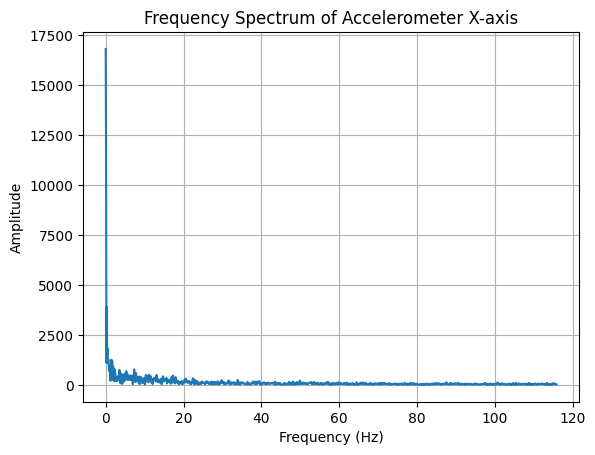

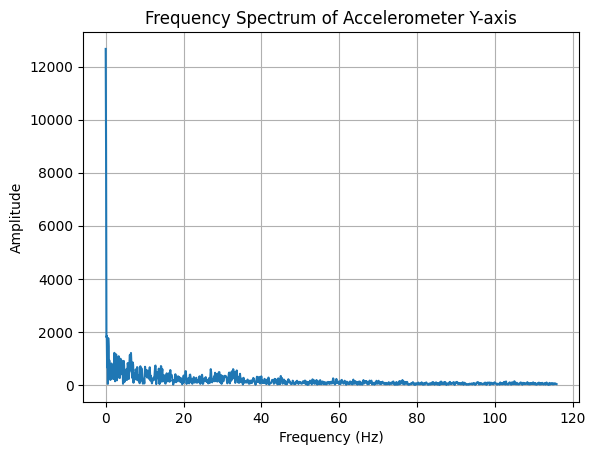

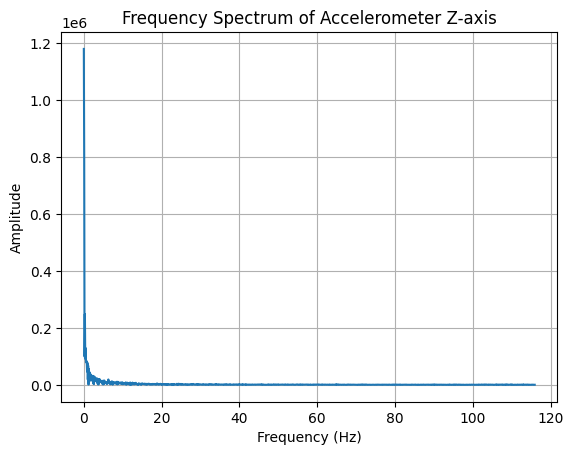

In [30]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter

sampling_rate = 232

accel_data = np.array(accel_data)

# Fourier Transform for each axis
def plot_fft(signal, title):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sampling_rate)
    plt.figure()
    plt.plot(xf[:N // 2], np.abs(yf[:N // 2]))
    plt.title(f'Frequency Spectrum of {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

# Apply FFT to each axis
plot_fft(accel_data[:, 1], 'Accelerometer X-axis')
plot_fft(accel_data[:, 2], 'Accelerometer Y-axis')
plot_fft(accel_data[:, 3], 'Accelerometer Z-axis')


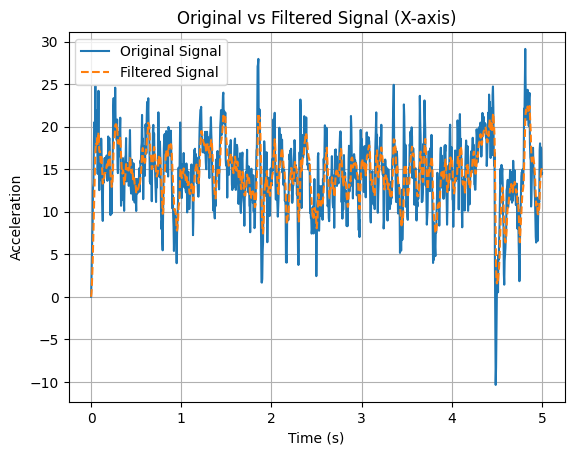

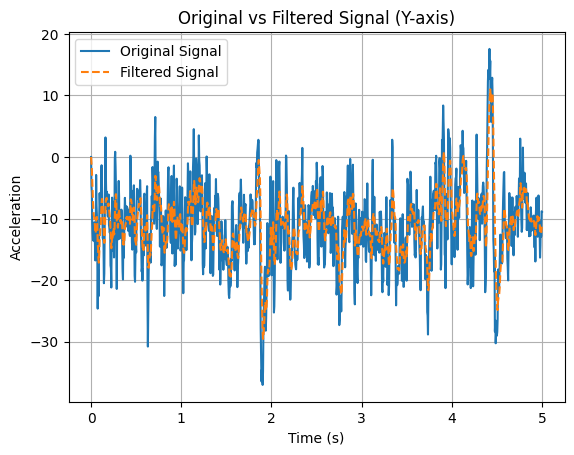

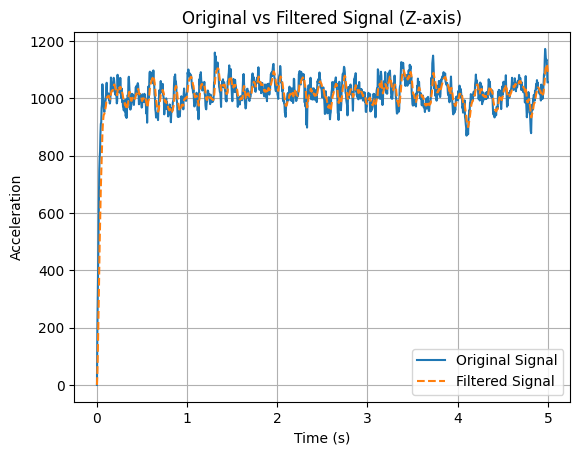

In [52]:
def low_pass_filter(raw_data, alpha):
    filtered_data = np.zeros_like(raw_data)
    filtered_data[0] = raw_data[0]  # Initialize with the first raw data point
    
    for n in range(1, len(raw_data)):
        filtered_data[n] = alpha * raw_data[n] + (1 - alpha) * filtered_data[n - 1]
    
    return filtered_data

alpha = 0.213
# Apply LPF to accelerometer data (X, Y, Z axes)
filtered_x_lpf = low_pass_filter(accel_data[0:1160, 1], alpha)
filtered_y_lpf = low_pass_filter(accel_data[0:1160, 2], alpha)
filtered_z_lpf = low_pass_filter(accel_data[0:1160, 3], alpha)

# Plot original vs filtered signals
def plot_original_vs_filtered(original, filtered, axis_label):
    plt.figure()
    plt.plot(t, original, label='Original Signal')
    plt.plot(t, filtered, label='Filtered Signal', linestyle='--')
    plt.title(f'Original vs Filtered Signal ({axis_label}-axis)')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.grid()
    plt.show()

t = np.linspace(0, len(accel_data[0:1160]) / sampling_rate, len(accel_data[0:1160]))

plot_original_vs_filtered(accel_data[:1160, 1], filtered_x_lpf, 'X')
plot_original_vs_filtered(accel_data[0:1160, 2], filtered_y_lpf, 'Y')
plot_original_vs_filtered(accel_data[0:1160, 3], filtered_z_lpf, 'Z')

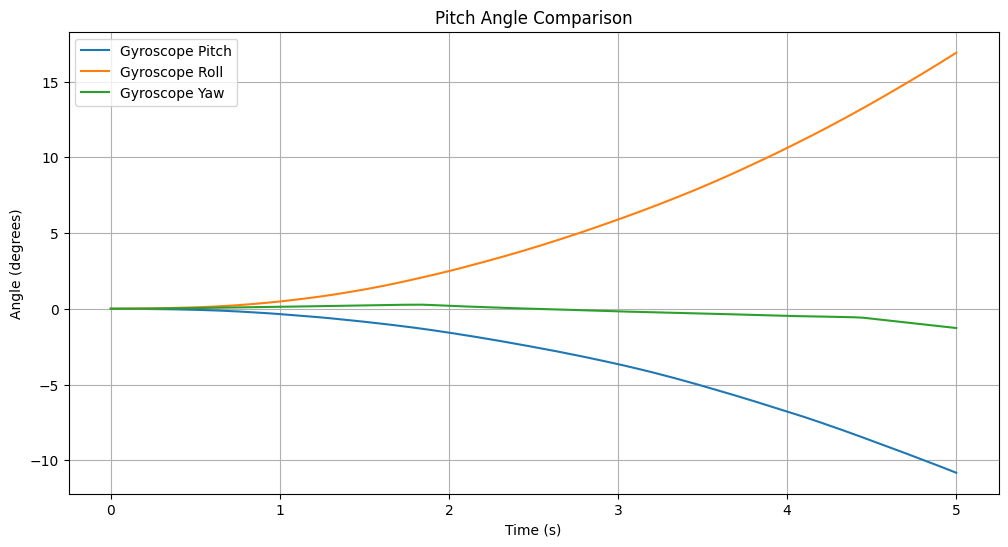

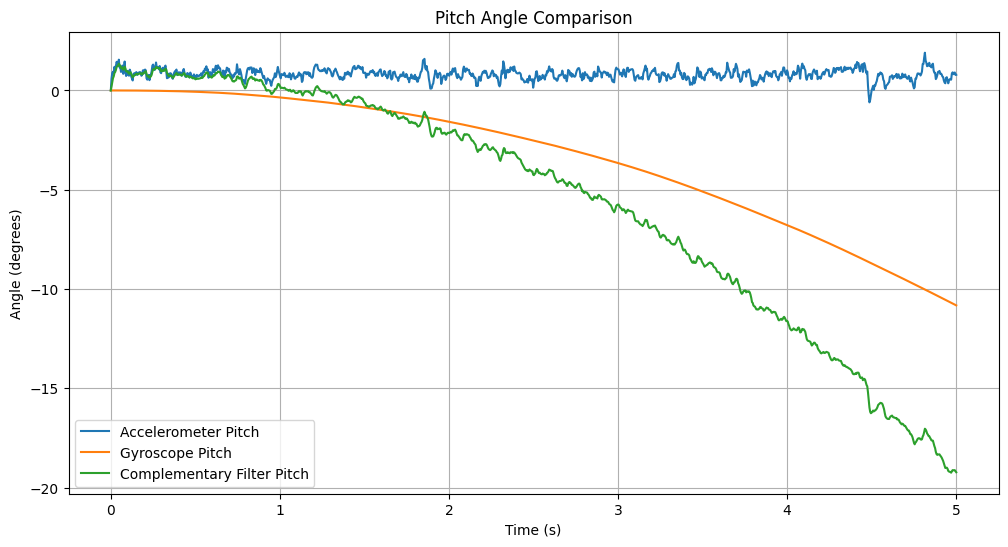

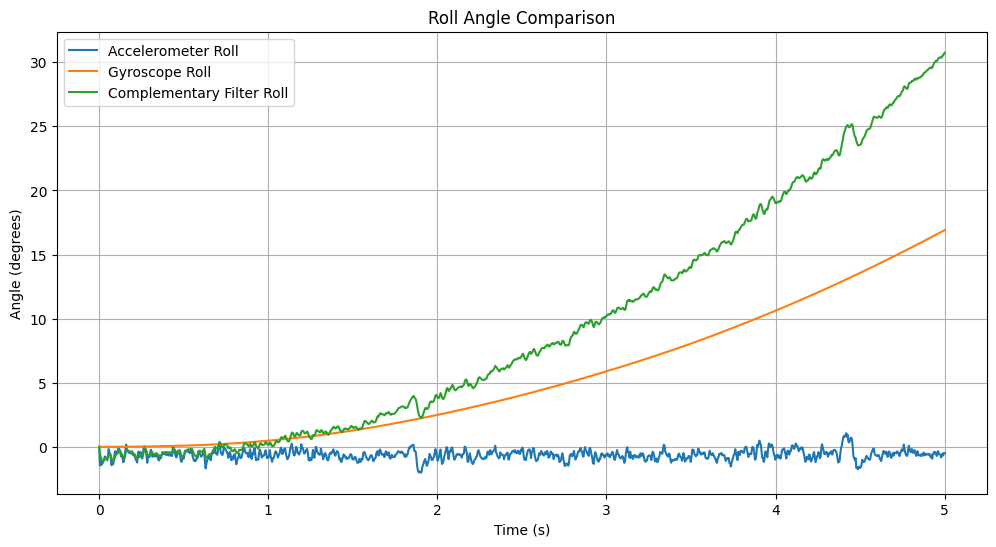

In [62]:
g = 9.81  # Gravity (m/s^2)

# Accelerometer Pitch and Roll Calculations
accel_x = accel_data[0:1160, 1]
accel_y = accel_data[0:1160, 2]
accel_z = accel_data[0:1160, 3]

# Gyroscope data (angular velocities in rad/s)
gyro_x = accel_data[0:1160, 6]
gyro_y = accel_data[0:1160, 7]
gyro_z = accel_data[0:1160, 8]

# Pitch and Roll from Accelerometer (in degrees)
accel_pitch = np.arctan2(accel_x, accel_z) * (180 / np.pi)
accel_roll = np.arctan2(accel_y, accel_z) * (180 / np.pi)


dt = 1 / sampling_rate

gyro_pitch = np.zeros_like(accel_x)
gyro_roll = np.zeros_like(accel_y)
gyro_yaw = np.zeros_like(accel_y)

for i in range(1, len(accel_x)):
    gyro_pitch[i] = gyro_pitch[i-1] + gyro_x[i] * dt
    gyro_roll[i] = gyro_roll[i-1] + gyro_y[i] * dt
    gyro_yaw[i] = gyro_yaw[i-1] + gyro_z[i] * dt

# Complementary Filter for Pitch and Roll
alpha_cf = 0.65  # Complementary filter constant

# Initialize arrays
comp_pitch = np.zeros_like(gyro_pitch)
comp_roll = np.zeros_like(gyro_roll)

# Complementary filter implementation
for i in range(1, len(accel_x)):
    comp_pitch[i] = alpha_cf * (comp_pitch[i-1] + gyro_pitch[i]) + (1 - alpha_cf) * accel_pitch[i]
    comp_roll[i] = alpha_cf * (comp_roll[i-1] + gyro_roll[i]) + (1 - alpha_cf) * accel_roll[i]

t = np.linspace(0, len(accel_x) / sampling_rate, len(accel_x))

# Plotting gyro data
plt.figure(figsize=(12, 6))
plt.plot(t, gyro_pitch, label='Gyroscope Pitch')
plt.plot(t, gyro_roll, label='Gyroscope Roll')
plt.plot(t, gyro_yaw, label='Gyroscope Yaw')
plt.title('Pitch Angle Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.grid()
plt.show()

# Plotting Pitch Comparison
plt.figure(figsize=(12, 6))
plt.plot(t, accel_pitch, label='Accelerometer Pitch')
plt.plot(t, gyro_pitch, label='Gyroscope Pitch')
plt.plot(t, comp_pitch, label='Complementary Filter Pitch')
plt.title('Pitch Angle Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.grid()
plt.show()

# Plotting Roll Comparison
plt.figure(figsize=(12, 6))
plt.plot(t, accel_roll, label='Accelerometer Roll')
plt.plot(t, gyro_roll, label='Gyroscope Roll')
plt.plot(t, comp_roll, label='Complementary Filter Roll')
plt.title('Roll Angle Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.grid()
plt.show()

In [26]:
ble.send_command(CMD.START_RECORD_DATA, "20")

Received msg : Time:115761.000, Data: -965.337, 214.963, -150.137, -98.840, 124.931, -491.232, 213.945, -298.140, -790.319, 653.478
Received msg : Time:115768.000, Data: -970.043, 216.140, -149.908, -98.784, 124.744, -491.245, 213.953, -298.153, -1058.019, 727.064
Received msg : Time:115771.000, Data: -968.045, 214.972, -150.461, -98.834, 124.988, -491.273, 213.999, -298.218, -1275.156, 786.825
Received msg : Time:115773.000, Data: -968.086, 213.840, -152.201, -98.934, 125.441, -491.296, 214.011, -298.241, -1451.291, 835.387
Received msg : Time:115781.000, Data: -964.797, 212.461, -152.320, -98.971, 125.637, -491.328, 214.047, -298.305, -1594.170, 874.837
Received msg : Time:115783.000, Data: -962.498, 211.988, -151.863, -98.966, 125.616, -491.345, 214.063, -298.324, -1710.057, 906.840
Received msg : Time:115791.000, Data: -960.727, 211.144, -147.801, -98.745, 124.992, -491.376, 214.098, -298.418, -1804.026, 932.704
Received msg : Time:115793.000, Data: -960.028, 209.720, -148.106, -98